In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib as mp
import os

import traceback

In [38]:
mp.rcParams['legend.fontsize'] = 45

pd.set_option('display.expand_frame_repr', False)
fn=0
path='./result/'

#Taking any image from the sample images
#In case of slanted image, straighten it using image-straighten.py, then use it
img = cv.imread('1646641368038.jpg')
print(img.shape[1])
col=img[:,5:6]
print(col)
k = col.shape[0]
print(k)
print(col[k-1]==255)

2009
[[[164 169 172]]

 [[163 168 171]]

 [[160 165 168]]

 ...

 [[146 151 154]]

 [[146 151 154]]

 [[147 152 155]]]
1021
[[False False False]]


In [39]:
# In[findFeaturPoints]
def findCapPoints(img):
    cpoints=[]
    dpoints=[]
    for i in range(img.shape[1]):
        col = img[:,i:i+1]
        k = col.shape[0]
        while k > 0:
            if col[k-1]==255:
                dpoints.append((i,k))
                break
            k-=1
        
        for j in range(col.shape[0]):
            if col[j]==255:
                cpoints.append((i,j))
                break
    return cpoints,dpoints

In [40]:
# In[wordSegment]
#*****************************************************************************#
def wordSegment(textLines):
    wordImgList=[]
    counter=0
    cl=0
    for txtLine in textLines:
        gray = cv.cvtColor(txtLine, cv.COLOR_BGR2GRAY)
        th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
        final_thr = cv.dilate(threshed,None,iterations = 1)

        plt.imshow(final_thr)
        plt.show()
        
        contours, hierarchy = cv.findContours(final_thr,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
        boundingBoxes = [cv.boundingRect(c) for c in contours]
        (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b: b[1][0], reverse=False))
       
        for cnt in contours:
            area = cv.contourArea(cnt)
 
 #print area
            if area > 10000:
                print ('Area= ',area)
                x,y,w,h = cv.boundingRect(cnt)
                print (x,y,w,h)
                letterBgr = txtLine[0:txtLine.shape[1],x:x+w]
                wordImgList.append(letterBgr)
                go= cv.cvtColor(letterBgr, cv.COLOR_BGR2GRAY)
                th, letterBgr = cv.threshold(go, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
                letterBgr = fitToSize(letterBgr)
                path = 'G:\\Study\\11-30-2020\\Demo Ocr\\Final OCR\\Sentence'
                
                cv.imwrite(os.path.join(path , "result" + str(counter) +".jpg"),letterBgr)
                cv.waitKey(0)
                counter=counter+1
        cl=cl+1
       
    return wordImgList

In [41]:
# In[fitToSize]
#*****************************************************************************#
def fitToSize(thresh1):
    
    mask = thresh1 > 0
    coords = np.argwhere(mask)

    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0)    # slices are exclusive at the top
    cropped = thresh1[x0:x1,y0:y1]
    return cropped
   
#*****************************************************************************#

In [42]:
# In[lineSegment]
#*****************************************************************************#
def lineSegment(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
   
    upper=[]
    lower=[]
    flag=True
    for i in range(threshed.shape[0]):

        col = threshed[i:i+1,:]
        cnt=0
        if flag:
            cnt=np.count_nonzero(col == 255)
            if cnt >0:
                upper.append(i)
                flag=False
        else:
            cnt=np.count_nonzero(col == 255)
            if cnt <1:
                lower.append(i)
                flag=True
    textLines=[]
    if len(upper)!= len(lower):lower.append(threshed.shape[0])
#    print upper
#    print lower
    for i in range(len(upper)):
        timg=img[upper[i]:lower[i],0:]
        
        if timg.shape[0]>5:
#            plt.imshow(timg)
#            plt.show()
            timg=cv.resize(timg,((timg.shape[1]*5,timg.shape[0]*8)))
            textLines.append(timg)

    return textLines
#*****************************************************************************#

In [43]:
# In[baselines]:
##******************************************************************************#
def baselines(letter2, cpoints, dpoints):
##-------------------------Creating upper baseline-------------------------------##
    colu = []
    for i in range(len(cpoints)):
        colu.append(cpoints[i][1])
    
    maxyu = max(colu)
    minyu = min(colu)
    avgu = (maxyu + minyu) // 2
    meanu = np.around(np.mean(colu)).astype(int)
    print('Upper:: Max, min, avg, mean:: ',maxyu, minyu, avgu, meanu)
    ##-------------------------------------------------------------------------------##
##-------------------------Creating lower baseline process 1--------------------------##
    cold = []
    for i in range(len(dpoints)):
        cold.append(dpoints[i][1])
    
    maxyd = max(cold)
    minyd = min(cold)
    avgd = (maxyd + minyd) // 2
    meand = np.around(np.mean(cold)).astype(int)
    print('Lower:: Max, min, avg, mean:: ',maxyd, minyd, avgd, meand)
##-------------------------Creating lower baseline process 2---------------------------##
    cn = []
    count = 0

    for i in range(h):
        for j in range(w):
            if(letterGray[i,j] == 255):
                count+=1
        if(count != 0):
            cn.append(count)
            count = 0    
    maxindex = cn.index(max(cn))
    print('Max pixels at: ',maxindex)
##------------------Printing upper and lower baselines-----------------------------##
    
    cv.line(letter2,(0,meanu),(w,meanu),(255,0,0),2)
    lb = 0
    if(maxindex > meand):
        lb = maxindex
        cv.line(letter2,(0,maxindex),(w,maxindex),(255,0,0),2)
    else:
        lb = meand
        cv.line(letter2,(0,meand),(w,meand),(255,0,0),2)
        
    plt.imshow(letter2)
    plt.show()
    return meanu, lb
##******************************************************************************###

In [44]:
# In[histogram]:
##*******************************************************************************###
def histogram(letter2, upper_baseline, lower_baseline):
    ##------------Making Histograms (Default)------------------------######
    cropped = letter2[upper_baseline:lower_baseline,0:w]
    plt.imshow(cropped)
    plt.show()
    colcnt = np.sum(cropped==255, axis=0)
    x = list(range(len(colcnt)))
    plt.plot(colcnt)
    plt.fill_between(x, colcnt, 1, facecolor='blue', alpha=0.5)
    plt.show()  
    return colcnt     
####---------------------------------------------------------------------------#####

In [45]:
# In[Visualize]:
##*******************************************************************************###
def visualize(letter2, upper_baseline, lower_baseline, min_pixel_threshold, min_separation_threshold, min_round_letter_threshold):
    seg = []
    seg1 = []
    seg2 = []
   ## Check if pixel count is less than min_pixel_threshold, add segmentation point
    for i in range(len(colcnt)):
        if(colcnt[i] < min_pixel_threshold):
            seg1.append(i)
          
    ## Check if 2 consequtive seg points are greater than min_separation_threshold in distance
    for i in range(len(seg1)-1):
        if(seg1[i+1]-seg1[i] > min_separation_threshold):
            seg2.append(seg1[i])
##------------Modified segmentation for removing circles----------------------------###            
    arr=[]
    for i in (seg2):
        arr1 = []
        j = upper_baseline
        while(j <= lower_baseline):
            if(letterGray[j,i] == 255):
                arr1.append(1)
            else:
                arr1.append(0)
            j+=1
        arr.append(arr1)
    print('At arr Seg here: ', seg2)
    
    ones = []
    for i in (arr):
        ones1 = []
        for j in range(len(i)):
            if (i[j] == 1):
                ones1.append([j])
        ones.append(ones1)
    
    diffarr = []
    for i in (ones):
        diff = i[len(i)-1][0] - i[0][0]
        diffarr.append(diff)
    print('Difference array: ',diffarr)
    
    for i in range(len(seg2)):
        if(diffarr[i] < min_round_letter_threshold):
            seg.append(seg2[i])
##---------------------------------------------------------------------------##
## Make the Cut 
    for i in range(len(seg)):
        letter3 = cv.line(letter2,(seg[i],0),(seg[i],h),(255,0,0),2)
    
    print("Does it work::::")
    plt.imshow(letter2)
    plt.show()
    return seg 


In [46]:
# In[segmentCharacters]
def segmentCharacters(seg,lettergray):
    s=0
    wordImgList = []
    global fn
    for i in range(len(seg)):
        if i==0:
            s=seg[i]
            if s > 15:
                wordImg = lettergray[0:,0:s]
                cntx=np.count_nonzero(wordImg == 255) 
                print ('count',cntx)
                plt.imshow(wordImg)
                plt.show()
                fn=fn+1
            else:
                continue
        elif (i != (len(seg)-1)):
            if seg[i]-s > 15:
                wordImg = lettergray[0:,s:seg[i]]
                cntx=np.count_nonzero(wordImg == 255) 
                print ('count',cntx)
                plt.imshow(wordImg)
                plt.show()
                fn=fn+1
                s=seg[i]
            else:
                continue
        else:
            wordImg = lettergray[0:,seg[len(seg)-1]:]
            cntx=np.count_nonzero(wordImg == 255) 
            print ('count',cntx)
            plt.imshow(wordImg)
            plt.show()
            fn=fn+1
        wordImgList.append(wordImg)

    return wordImgList


No. of Lines 2


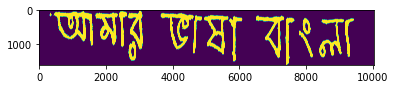

Area=  713652.5
449 27 1181 1036
Area=  356555.0
1688 66 677 986
Area=  109050.5
2386 30 254 1066
Area=  293380.0
2676 0 444 1161
Area=  107613.0
2680 917 239 594
Area=  479877.5
3644 89 994 1078
Area=  92285.0
4616 152 274 1136
Area=  467314.5
4948 148 736 1169
Area=  148202.5
5685 177 415 1349
Area=  398697.0
6506 165 852 1262
Area=  144227.0
7388 224 275 1408
Area=  73458.0
7788 606 426 808
Area=  88815.5
7904 236 246 487
Area=  272247.0
8400 262 743 1142
Area=  113558.0
9165 243 279 1150


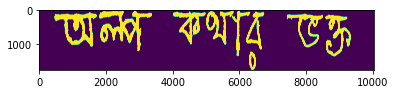

Area=  782179.0
456 62 1279 1039
Area=  737704.0
1806 6 1585 1223
Area=  372661.0
4019 28 976 996
Area=  323298.0
5002 10 834 1026
Area=  163854.0
5790 0 534 1368
Area=  287387.5
6208 48 551 1134
Area=  91081.5
6298 1233 216 551
Area=  499866.0
7425 108 1089 1003
Area=  362376.0
8584 139 765 1241
No. of Words 24
LetterGray shape:  (1632, 1181, 3)
Upper:: Max, min, avg, mean::  827 0 413 52
Lower:: Max, min, avg, mean::  1042 138 590 709
Max pixels at:  133


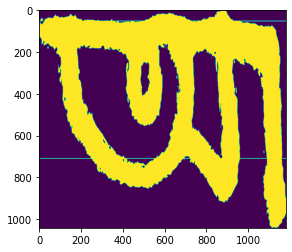

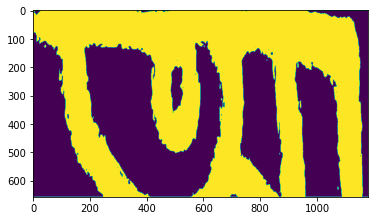

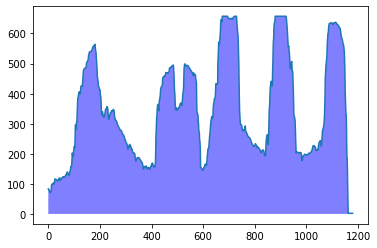

At arr Seg here:  []
Difference array:  []
Does it work::::


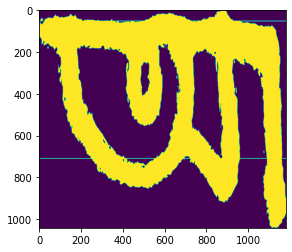

LetterGray shape:  (1632, 677, 3)
Upper:: Max, min, avg, mean::  86 0 43 26
Lower:: Max, min, avg, mean::  983 88 535 641
Max pixels at:  86


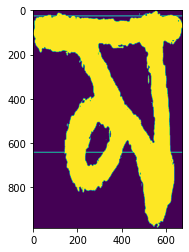

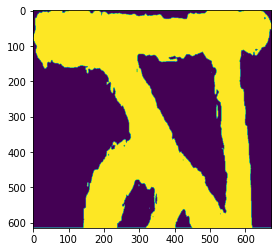

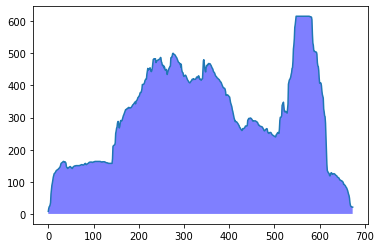

At arr Seg here:  []
Difference array:  []
Does it work::::


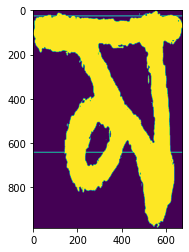

LetterGray shape:  (1632, 254, 3)
Upper:: Max, min, avg, mean::  137 0 68 18
Lower:: Max, min, avg, mean::  1059 118 588 519
Max pixels at:  97


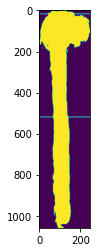

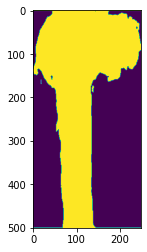

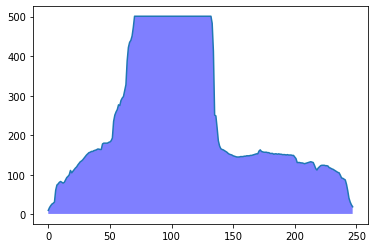

At arr Seg here:  []
Difference array:  []
Does it work::::


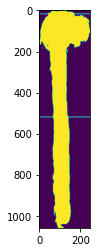

LetterGray shape:  (1632, 444, 3)
Upper:: Max, min, avg, mean::  791 0 395 91
Lower:: Max, min, avg, mean::  1488 225 856 1270
Max pixels at:  170


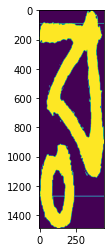

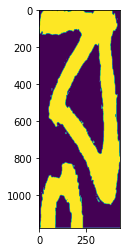

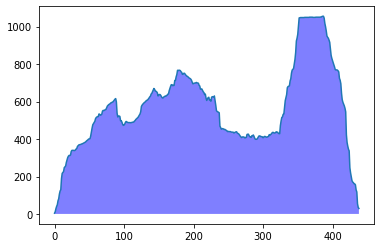

At arr Seg here:  []
Difference array:  []
Does it work::::


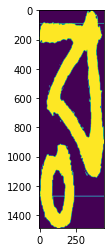

LetterGray shape:  (1632, 239, 3)
Upper:: Max, min, avg, mean::  55 0 27 7
Lower:: Max, min, avg, mean::  1404 140 772 1350
Max pixels at:  55


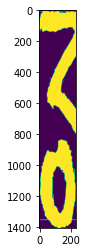

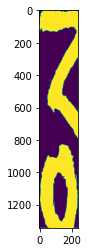

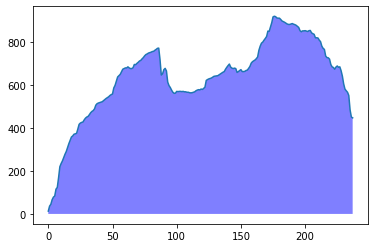

At arr Seg here:  []
Difference array:  []
Does it work::::


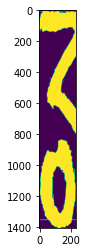

LetterGray shape:  (1632, 994, 3)
Upper:: Max, min, avg, mean::  82 0 41 22
Lower:: Max, min, avg, mean::  1193 113 653 611
Max pixels at:  82


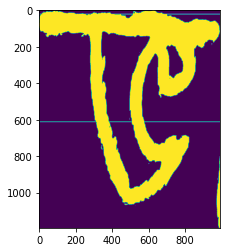

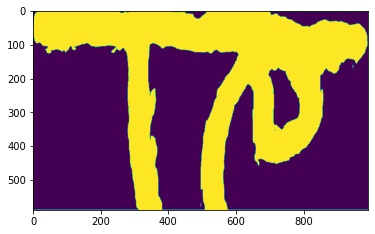

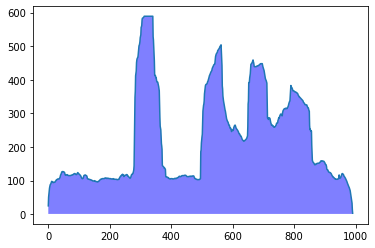

At arr Seg here:  []
Difference array:  []
Does it work::::


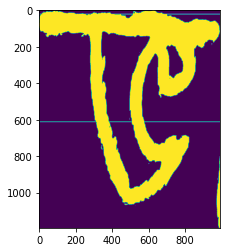

LetterGray shape:  (1632, 274, 3)
Upper:: Max, min, avg, mean::  590 0 295 49
Lower:: Max, min, avg, mean::  1131 118 624 495
Max pixels at:  56


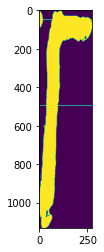

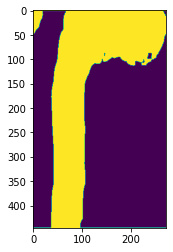

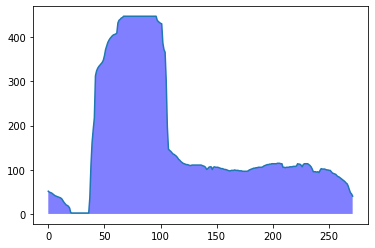

At arr Seg here:  []
Difference array:  []
Does it work::::


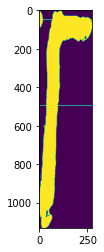

LetterGray shape:  (1632, 736, 3)
Upper:: Max, min, avg, mean::  80 0 40 19
Lower:: Max, min, avg, mean::  1161 112 636 802
Max pixels at:  80


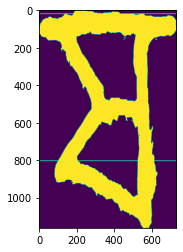

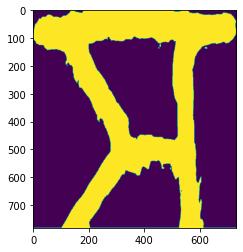

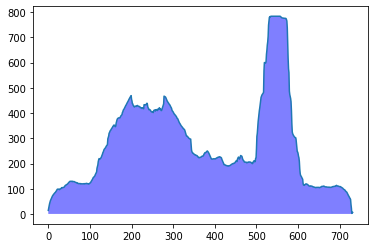

At arr Seg here:  []
Difference array:  []
Does it work::::


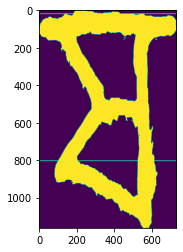

LetterGray shape:  (1632, 415, 3)
Upper:: Max, min, avg, mean::  120 0 60 46
Lower:: Max, min, avg, mean::  1340 126 733 502
Max pixels at:  120


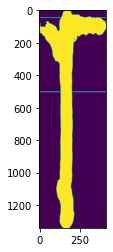

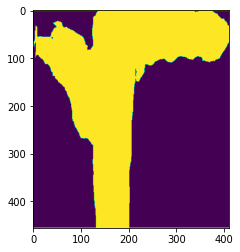

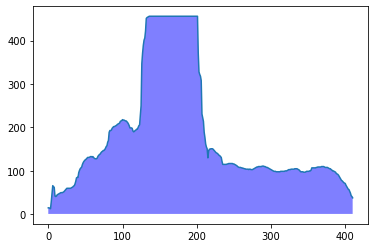

At arr Seg here:  []
Difference array:  []
Does it work::::


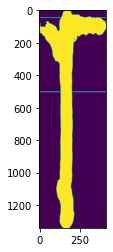

LetterGray shape:  (1632, 852, 3)
Upper:: Max, min, avg, mean::  57 0 28 29
Lower:: Max, min, avg, mean::  1255 109 682 614
Max pixels at:  57


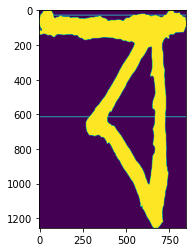

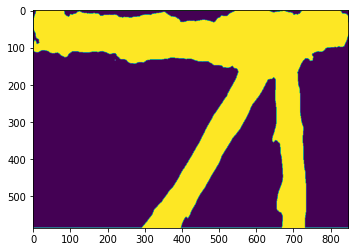

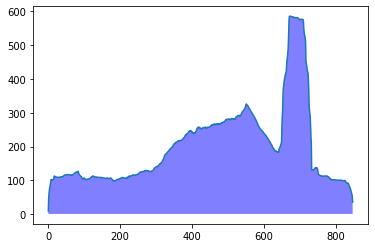

At arr Seg here:  []
Difference array:  []
Does it work::::


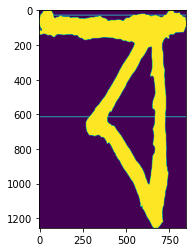

LetterGray shape:  (1632, 275, 3)
Upper:: Max, min, avg, mean::  559 0 279 27
Lower:: Max, min, avg, mean::  1405 100 752 699
Max pixels at:  96


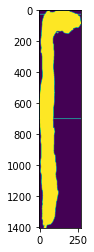

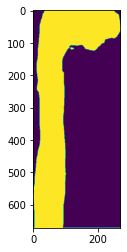

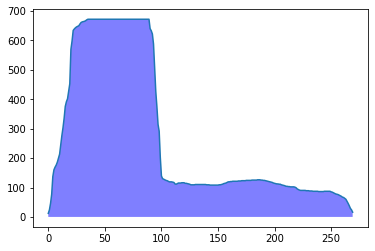

At arr Seg here:  []
Difference array:  []
Does it work::::


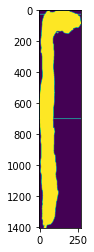

LetterGray shape:  (1632, 426, 3)
Upper:: Max, min, avg, mean::  1062 0 531 283
Lower:: Max, min, avg, mean::  1175 453 814 817
Max pixels at:  430


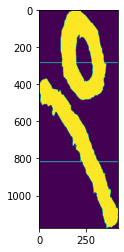

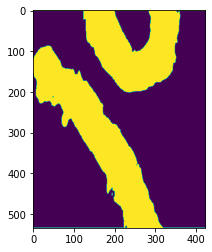

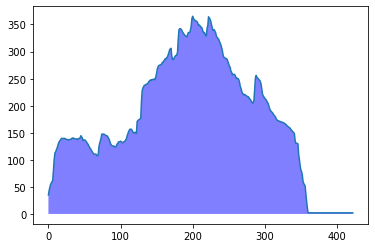

At arr Seg here:  []
Difference array:  []
Does it work::::


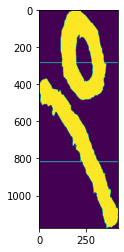

LetterGray shape:  (1632, 246, 3)
Upper:: Max, min, avg, mean::  284 0 142 64
Lower:: Max, min, avg, mean::  1157 598 877 854
Max pixels at:  142


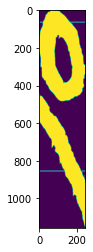

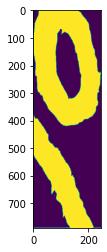

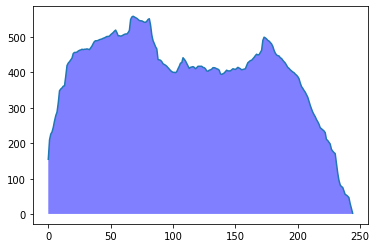

At arr Seg here:  []
Difference array:  []
Does it work::::


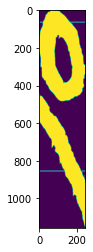

LetterGray shape:  (1632, 743, 3)
Upper:: Max, min, avg, mean::  895 0 447 82
Lower:: Max, min, avg, mean::  1143 79 611 897
Max pixels at:  61


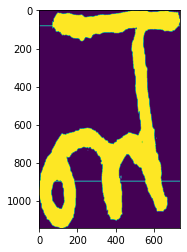

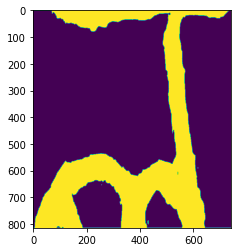

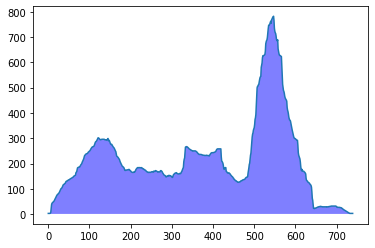

At arr Seg here:  [5]
Difference array:  [45]
Does it work::::


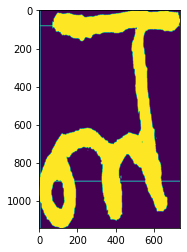

LetterGray shape:  (1632, 279, 3)
Upper:: Max, min, avg, mean::  175 0 87 31
Lower:: Max, min, avg, mean::  1154 51 602 612
Max pixels at:  78


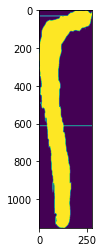

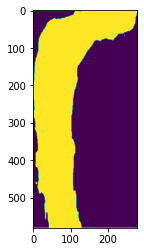

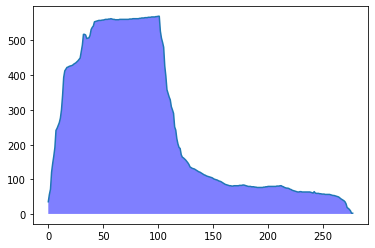

At arr Seg here:  []
Difference array:  []
Does it work::::


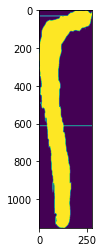

LetterGray shape:  (1784, 1279, 3)
Upper:: Max, min, avg, mean::  118 0 59 48
Lower:: Max, min, avg, mean::  1030 134 582 690
Max pixels at:  118


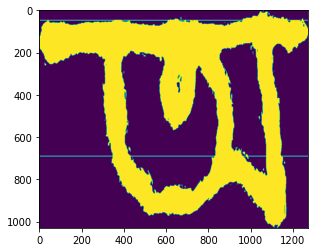

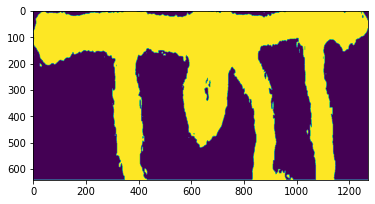

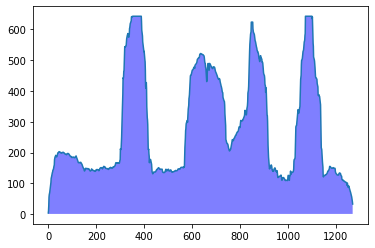

At arr Seg here:  []
Difference array:  []
Does it work::::


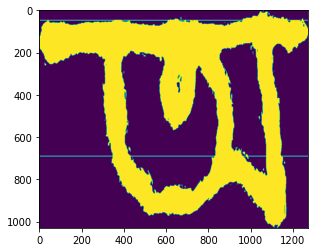

LetterGray shape:  (1784, 1585, 3)
Upper:: Max, min, avg, mean::  326 0 163 81
Lower:: Max, min, avg, mean::  1217 156 686 705
Max pixels at:  132


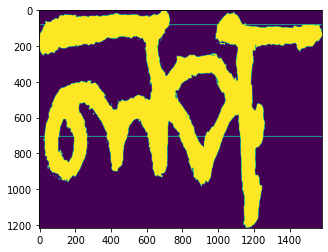

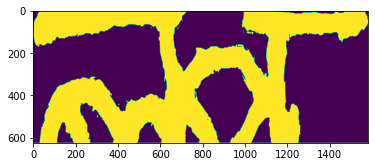

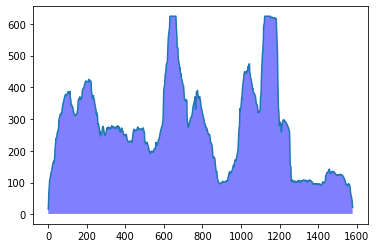

At arr Seg here:  []
Difference array:  []
Does it work::::


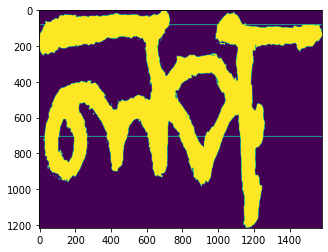

LetterGray shape:  (1784, 976, 3)
Upper:: Max, min, avg, mean::  69 0 34 42
Lower:: Max, min, avg, mean::  988 107 547 529
Max pixels at:  69


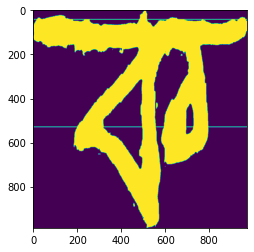

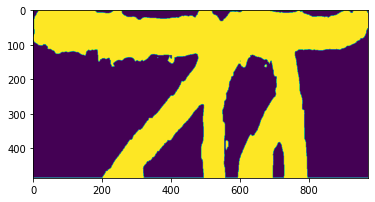

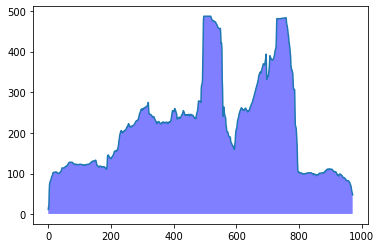

At arr Seg here:  []
Difference array:  []
Does it work::::


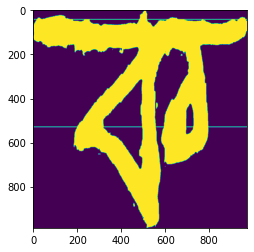

LetterGray shape:  (1784, 834, 3)
Upper:: Max, min, avg, mean::  694 0 347 80
Lower:: Max, min, avg, mean::  1022 138 580 623
Max pixels at:  136


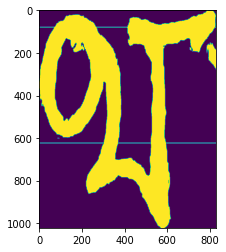

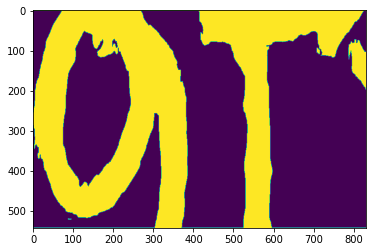

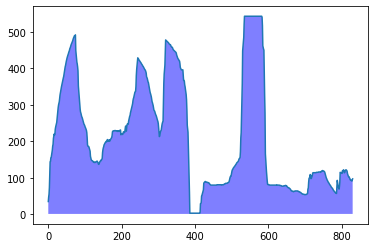

At arr Seg here:  []
Difference array:  []
Does it work::::


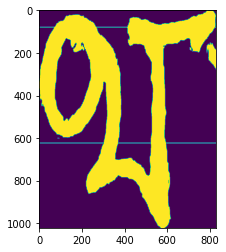

LetterGray shape:  (1784, 534, 3)
Upper:: Max, min, avg, mean::  276 0 138 78
Lower:: Max, min, avg, mean::  1671 164 917 671
Max pixels at:  85


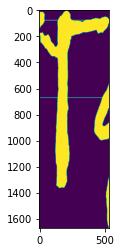

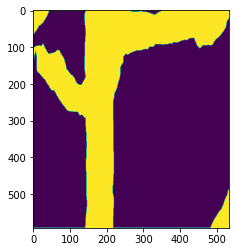

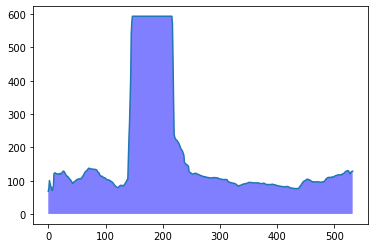

At arr Seg here:  []
Difference array:  []
Does it work::::


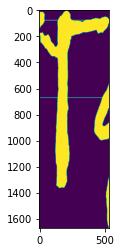

LetterGray shape:  (1784, 551, 3)
Upper:: Max, min, avg, mean::  478 0 239 69
Lower:: Max, min, avg, mean::  1733 86 909 1158
Max pixels at:  79


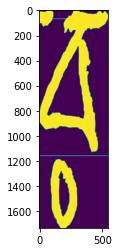

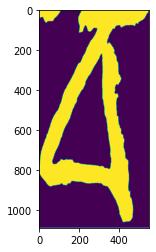

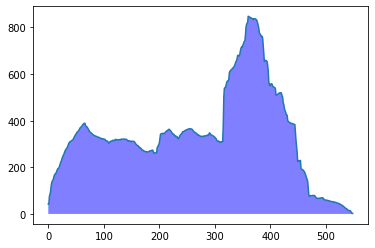

At arr Seg here:  []
Difference array:  []
Does it work::::


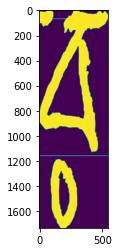

LetterGray shape:  (1784, 216, 3)
Upper:: Max, min, avg, mean::  478 0 239 157
Lower:: Max, min, avg, mean::  1733 1400 1566 1681
Max pixels at:  799


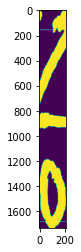

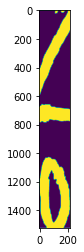

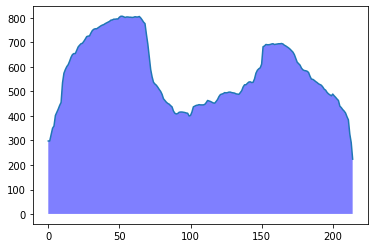

At arr Seg here:  []
Difference array:  []
Does it work::::


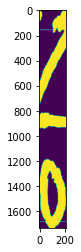

LetterGray shape:  (1784, 1089, 3)
Upper:: Max, min, avg, mean::  103 0 51 29
Lower:: Max, min, avg, mean::  1002 97 549 581
Max pixels at:  102


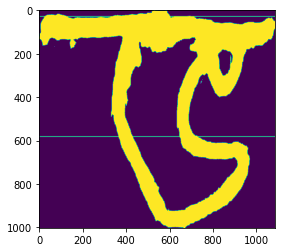

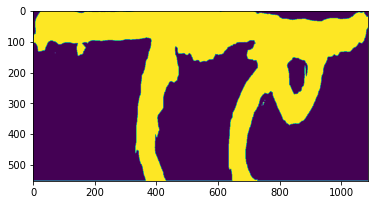

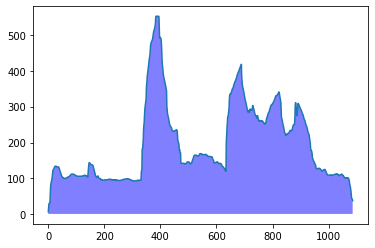

At arr Seg here:  []
Difference array:  []
Does it work::::


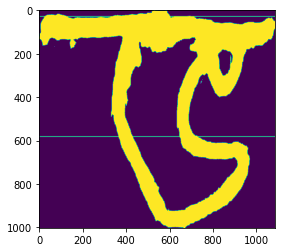

LetterGray shape:  (1784, 765, 3)
Upper:: Max, min, avg, mean::  580 0 290 86
Lower:: Max, min, avg, mean::  1242 108 675 1037
Max pixels at:  87


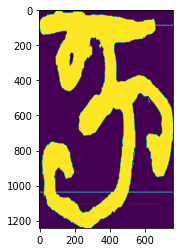

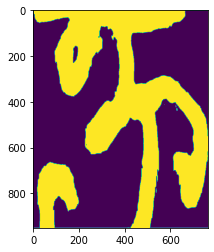

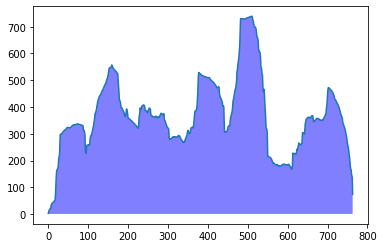

At arr Seg here:  []
Difference array:  []
Does it work::::


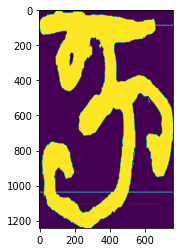

Original Image


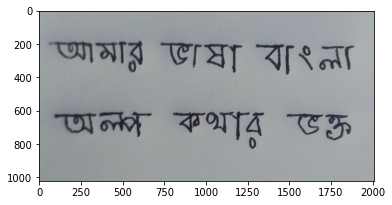

NoneType: None


In [47]:
# In[Main]:
try:
    textLines=lineSegment(img)
    print ('No. of Lines',len(textLines))
    imgList=wordSegment(textLines)
    print ('No. of Words',len(imgList))
    counter = 0
    for letterGray in imgList:
        print ('LetterGray shape: ',letterGray.shape)
        gray = cv.cvtColor(letterGray, cv.COLOR_BGR2GRAY)
        th, letterGray = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
        letterGray = fitToSize(letterGray)
        letter2 = letterGray.copy()
        letterGray = cv.dilate(letterGray,None,iterations = 4)

        h = letterGray.shape[0]
        w = letterGray.shape[1]
        
        cpoints, dpoints=findCapPoints(letterGray)        
        meanu, lb = baselines(letter2, cpoints, dpoints)
        
##-----------Final Baseline row numbers-----------------------####
#       Ignore all points avove and below these rows 
        upper_baseline = meanu
        lower_baseline = lb
        
##--------------------Make histogram-------------------------------------###   
        
        colcnt = histogram(letter2, upper_baseline, lower_baseline)
        
###------------------------Visualize segmentation------------------------------#####        
        ## Tuning Parameters
        min_pixel_threshold = 5
        min_separation_threshold = 10
        min_round_letter_threshold = 190
        
        seg = visualize(letter2, upper_baseline, lower_baseline, min_pixel_threshold, min_separation_threshold, min_round_letter_threshold)
        wordImgList = segmentCharacters(seg,letterGray)
        #for i in wordImgList:
           # cv.imwrite("./result" + str(counter) +".jpeg",i)
           # counter=counter+1
        
###---------------------------------------------------------------------------#####        
        
    print('Original Image')         
    plt.imshow(img)
    plt.show()

except Exception as e:
    print ('Error Message ',e)
    cv.destroyAllWindows()
    traceback.print_exc()
    pass

traceback.print_exc() 